In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
(X_train,Y_train),(X_test,Y_test) = keras.datasets.reuters.load_data()

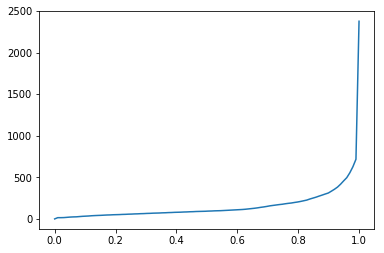

In [3]:
data_input_len_quantile_x = np.linspace(0, 1, num=100)
data_input_len_quantile_y = np.quantile(
    [len(x) for x in X_train] + [len(x) for x in X_test], data_input_len_quantile_x)
plt.plot(data_input_len_quantile_x, data_input_len_quantile_y)
plt.show()

In [4]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=256, padding='post', truncating='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=256, padding='post', truncating='post')
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((8982, 256), (8982,), (2246, 256), (2246,))

In [5]:
data_input_dim = max(np.max(X_train), np.max(X_test)) + 1
data_input_dim

30982

In [6]:
data_output_dim = max(np.max(Y_train), np.max(Y_test)) + 1
data_output_dim

46

In [143]:
class DNCCell(keras.layers.Layer):
    
    def __init__(self,
                 output_size,
                 word_size,
                 memory_size,
                 read_head_count=3,
                 **kwargs):
        self.output_size = output_size
        self.word_size = word_size
        self.memory_size = memory_size
        self.read_head_count = read_head_count
        self.state_size = (output_size,)
        self.state_size += (read_head_count * word_size,)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        read_vecs_size = self.word_size * self.read_head_count
        controller_input_size = input_shape[-1]
        controller_input_size += read_vecs_size
        interface_vec_size = read_vecs_size
        interface_vec_size += self.word_size * 3
        interface_vec_size += self.read_head_count * 5
        interface_vec_size += 3
        self.kernel_controller = self.add_weight(
            shape=(controller_input_size, self.output_size + interface_vec_size),
            initializer='glorot_normal', name='kernel_controller')
        self.bias_controller = self.add_weight(
            shape=(self.output_size + interface_vec_size,),
            initializer='glorot_normal', name='bias_controller')
        self.kernel_interface_vec_to_read_vecs = self.add_weight(
            shape=(interface_vec_size, read_vecs_size),
            initializer='glorot_normal', name='kernel_input_to_read_vecs')
        self.kernel_read_vecs_to_output = self.add_weight(
            shape=(read_vecs_size, self.output_size),
            initializer='glorot_normal', name='kernel_read_vecs_to_output')
        super().build(input_shape)
    
    def call(self, inputs, states):
        _, read_vecs_last = states
        
        # feeding controller with current input and last read vecs
        forward = K.concatenate([inputs, read_vecs_last])
        forward = forward @ self.kernel_controller + self.bias_controller
        forward = K.sigmoid(forward)
        
        # break down controller output into semi final output and interface vec
        interface_vec = forward[:,self.output_size:]
        forward = forward[:,:self.output_size]
        
        # break down interface vec
        read_keys = interface_vec[:,:self.word_size*self.read_head_count]
        read_keys = K.reshape(read_keys, (-1,self.read_head_count,self.word_size))
        read_stre = interface_vec[:,
            self.word_size*self.read_head_count:
            (self.word_size+1)*self.read_head_count]
        read_stre = K.softplus(read_stre) + 1
        write_key = interface_vec[:,
            (self.word_size+1)*self.read_head_count:
            (self.word_size+1)*self.read_head_count+self.word_size]
        write_stre = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size:
            (self.word_size+1)*self.read_head_count+self.word_size+1]
        write_stre = K.softplus(write_stre) + 1
        erase_vec = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size+1:
            (self.word_size+1)*self.read_head_count+self.word_size*2+1]
        erase_vec = K.sigmoid(erase_vec)
        write_vec = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size*2+1:
            (self.word_size+1)*self.read_head_count+self.word_size*3+1]
        free_gates = interface_vec[:,
            (self.word_size+1)*self.read_head_count+self.word_size*3+1:
            (self.word_size+2)*self.read_head_count+self.word_size*3+1]
        free_gates = K.sigmoid(free_gates)
        alloc_gate = interface_vec[:,
            (self.word_size+2)*self.read_head_count+self.word_size*3+1:
            (self.word_size+2)*self.read_head_count+self.word_size*3+2]
        alloc_gate = K.sigmoid(alloc_gate)
        write_gate = interface_vec[:,
            (self.word_size+2)*self.read_head_count+self.word_size*3+2:
            (self.word_size+2)*self.read_head_count+self.word_size*3+3]
        write_gate = K.sigmoid(write_gate)
        read_modes = interface_vec[:,
            (self.word_size+2)*self.read_head_count+self.word_size*3+3:
            (self.word_size+5)*self.read_head_count+self.word_size*3+3]
        read_modes = K.reshape(read_modes, (-1,self.read_head_count,3))
        read_modes = K.softmax(read_modes, axis=-1)
        
        # dummy read vecs
        read_vecs = interface_vec @ self.kernel_interface_vec_to_read_vecs
        
        # compute final output from semi final output and current read vecs
        forward = forward + read_vecs @ self.kernel_read_vecs_to_output
        
        return forward, [forward, read_vecs]
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [144]:
X = X_inputs = keras.layers.Input((None,), dtype='int32')
X = keras.layers.Embedding(data_input_dim, 16)(X)
X = keras.layers.RNN(DNCCell(32, 16, 64))(X)
X = keras.layers.Dense(data_output_dim, activation='softmax')(X)
M = keras.Model(X_inputs, X)
M.compile('nadam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_62 (Embedding)     (None, None, 16)          495712    
_________________________________________________________________
rnn_32 (RNN)                 (None, 32)                16498     
_________________________________________________________________
dense_30 (Dense)             (None, 46)                1518      
Total params: 513,728
Trainable params: 513,728
Non-trainable params: 0
_________________________________________________________________


In [114]:
M.fit(X_train, Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=50, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
])

Train on 8982 samples, validate on 2246 samples
Epoch 1/50
8982/8982 [==============================] - 10s 1ms/step - loss: 2.5583 - acc: 0.3367 - val_loss: 2.4183 - val_acc: 0.3629
Epoch 2/50
8982/8982 [==============================] - 8s 919us/step - loss: 2.3920 - acc: 0.3509 - val_loss: 2.4254 - val_acc: 0.3624
Epoch 3/50
6784/8982 [=====================>........] - ETA: 1s - loss: 12.2033 - acc: 0.1086

KeyboardInterrupt: 